# Term Deposit Marketing

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

Import necessary libraries

In [1]:
import random
import numpy as np
import pandas as pd
# import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Data Description

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

- marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

- y - has the client subscribed to a term deposit? (binary)

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Exploratory Data Analysis

This step investigate the following steps:
- Check for missing values
- Investigate the distribution of numerical variables
- Idenitfy number of categories in categorical features
- Compute the correlation between input and output variables

1. Check for missing value

In [4]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

This data set does not contain any missing values.

2. Investigate the distribution of numerical variables

In [5]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>, <Axes: >]], dtype=object)

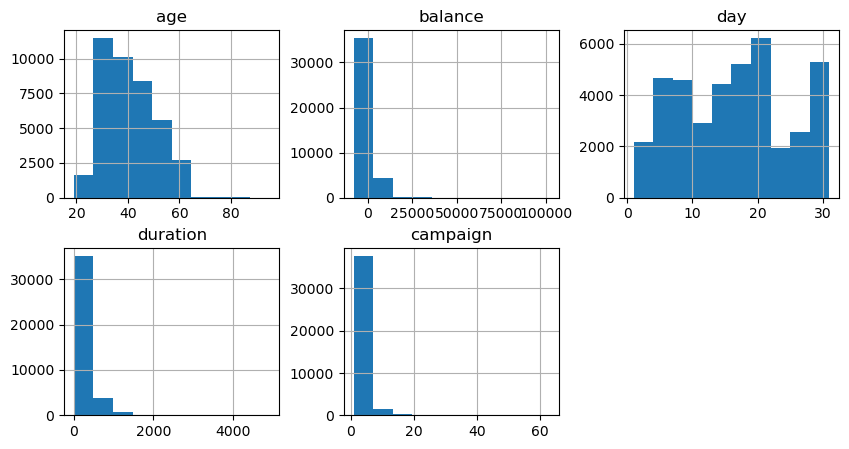

In [6]:
df.hist(figsize=(10, 5), layout=(2, 3))

The difference in range of numerical features is considerable. Standarization ('age' and 'day') might help increase the model accuracy. Other variables are positively skewed and has large outliers.

3. Idenitfy number of categories in categorical features

In [7]:
print('Number of unique values/Categories:')
for col in df.columns:
    print('- '+col+': ', df[col].nunique())

Number of unique values/Categories:
- age:  70
- job:  12
- marital:  3
- education:  4
- default:  2
- balance:  6849
- housing:  2
- loan:  2
- contact:  3
- day:  31
- month:  11
- duration:  1535
- campaign:  48
- y:  2


'education' and 'marital' are categorial object with 4 and 3 unique values, respectively.

In [8]:
df['education'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [9]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

In [10]:
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'default', 'housing', 'loan', 'contact'], drop_first=True, dtype=float)

In [11]:
df_dummies.head()

,age,education,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown
0,58,tertiary,2143,5,may,261,1,no,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,44,secondary,29,5,may,151,1,no,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,33,secondary,2,5,may,76,1,no,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,47,unknown,1506,5,may,92,1,no,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,33,unknown,1,5,may,198,1,no,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [12]:
education_dict = {'tertiary': 3, 'secondary': 2, 'unknown': 0, 'primary': 1}
df_dummies['ordinal_education'] = df_dummies.education.map(education_dict)
df_dummies = df_dummies.drop('education', axis=1)
df_dummies.head()

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
0,58,2143,5,may,261,1,no,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
1,44,29,5,may,151,1,no,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
2,33,2,5,may,76,1,no,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2
3,47,1506,5,may,92,1,no,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,33,1,5,may,198,1,no,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


In [13]:
cat_columns = df_dummies.select_dtypes(['object']).columns
cat_columns

Index(['month', 'y'], dtype='object')

In [14]:
df_dummies[cat_columns] = df_dummies[cat_columns].apply(lambda x: pd.factorize(x)[0])
df_dummies.head()

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,...,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
0,58,2143,5,0,261,1,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
1,44,29,5,0,151,1,0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
2,33,2,5,0,76,1,0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2
3,47,1506,5,0,92,1,0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,33,1,5,0,198,1,0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


4. Compute the correlation between input and output variables 

In [15]:
df_dummies.corr().style.background_gradient(cmap='coolwarm')

,age,balance,day,month,duration,campaign,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,ordinal_education
age,1.000000,0.081517,-0.011689,0.022965,-0.036270,0.016204,-0.020273,-0.028956,0.027956,0.084920,-0.005302,0.333164,0.001712,-0.057227,-0.155146,-0.058308,0.008052,0.043904,0.265630,-0.408589,-0.014857,-0.179606,0.000041,0.120689,0.010386,-0.161471
balance,0.081517,1.000000,0.011662,0.059003,0.014072,-0.008137,0.030232,-0.041461,0.011692,0.003044,0.072172,0.015917,0.015771,-0.033618,0.000575,-0.012655,0.010020,0.010672,0.023683,-0.007168,-0.070069,-0.049946,-0.080596,0.029116,-0.018851,0.052765
day,-0.011689,0.011662,1.000000,0.029379,-0.032983,0.165429,-0.006420,-0.035006,-0.003629,0.005355,0.026526,-0.002787,0.005080,-0.009461,-0.011183,0.031902,-0.005475,-0.009526,0.005243,-0.002806,0.006287,-0.050622,0.005838,0.037242,-0.054363,0.032272
month,0.022965,0.059003,0.029379,1.000000,0.015157,-0.069674,0.106168,-0.096244,0.000201,-0.004050,0.057380,0.022085,0.020090,-0.031792,0.032897,0.017347,0.061696,-0.003019,-0.011074,0.024891,-0.024357,-0.167039,-0.014806,0.077645,-0.506906,0.085241
duration,-0.036270,0.014072,-0.032983,0.015157,1.000000,-0.088387,0.461169,0.015951,0.000247,-0.007239,-0.010846,0.001675,0.008821,0.003569,-0.007175,-0.008469,0.017896,-0.007971,-0.029153,0.026703,-0.008597,0.022455,-0.003952,-0.040379,0.001928,0.004813
campaign,0.016204,-0.008137,0.165429,-0.069674,-0.088387,1.000000,-0.040350,-0.004635,-0.002619,0.002804,0.021105,-0.013881,0.004581,-0.010404,-0.008503,0.018915,-0.017052,0.017037,0.027962,-0.016179,0.012135,-0.054823,0.000582,0.061620,-0.012468,0.006220
y,-0.020273,0.030232,-0.006420,0.106168,0.461169,-0.040350,1.000000,-0.032859,-0.007191,-0.015248,0.020291,0.024343,0.005029,-0.014645,0.037384,0.000234,0.009463,-0.000018,-0.056863,0.051721,-0.006559,-0.054336,-0.031029,-0.000842,-0.088408,0.043828
job_blue-collar,-0.028956,-0.041461,-0.035006,-0.096244,0.015951,-0.004635,-0.032859,1.000000,-0.105624,-0.092525,-0.280381,-0.106864,-0.105974,-0.182215,-0.063781,-0.251692,-0.093266,-0.042557,0.125618,-0.087522,0.004706,0.156122,0.005674,0.006448,0.116781,-0.374273
job_entrepreneur,0.027956,0.011692,-0.003629,0.000201,0.000247,-0.002619,-0.007191,-0.105624,1.000000,-0.031889,-0.096634,-0.036831,-0.036524,-0.062801,-0.021982,-0.086747,-0.032144,-0.014667,0.044941,-0.048960,0.025645,0.003303,0.038244,-0.006114,-0.002439,0.045729
job_housemaid,0.084920,0.003044,0.005355,-0.004050,-0.007239,0.002804,-0.015248,-0.092525,-0.031889,1.000000,-0.084650,-0.032263,-0.031995,-0.055013,-0.019256,-0.075988,-0.028158,-0.012848,0.046431,-0.061803,0.000017,-0.086038,-0.016788,0.037439,-0.003592,-0.108081


- Input feature 'duration' has 0.461 correlation to output variable 'y'. This is expected as longer call duration can signify that customer is interested and might end up subscribing.

- 'job_management' and 'ordinal_education' has correlation 0.455.

- 'job_retired' and 'age' has correlation value 0.33.

## Training

In [16]:
X = df_dummies.loc[:, ~df_dummies.columns.isin(['y'])]
y = df_dummies['y']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
X_train.describe(), X_test.describe()

(                age        balance           day         month      duration  \
 count  30000.000000   30000.000000  30000.000000  30000.000000  30000.000000   
 mean      40.526233    1278.562833     16.043867      2.681567    254.252100   
 std        9.633432    2956.259009      8.274275      3.061657    257.963169   
 min       19.000000   -8019.000000      1.000000      0.000000      0.000000   
 25%       33.000000      55.000000      8.000000      0.000000     99.000000   
 50%       39.000000     408.000000     17.000000      2.000000    174.000000   
 75%       48.000000    1319.000000     21.000000      5.000000    312.000000   
 max       95.000000  102127.000000     31.000000     10.000000   3881.000000   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  30000.000000     30000.000000      30000.000000   30000.000000   
 mean       2.870033         0.233233          0.036033       0.026600   
 std        3.196073         0.422897          

In [19]:
scaler = StandardScaler().set_output(transform="pandas")
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X_train.describe(), scaled_X_test.describe()

(                age       balance           day         month      duration  \
 count  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04  3.000000e+04   
 mean   3.254286e-16 -2.013204e-17  5.021169e-17 -5.258016e-17 -5.708027e-17   
 std    1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00   
 min   -2.234572e+00 -3.145096e+00 -1.818180e+00 -8.758692e-01 -9.856304e-01   
 25%   -7.812749e-01 -4.138958e-01 -9.721699e-01 -8.758692e-01 -6.018483e-01   
 50%   -1.584335e-01 -2.944862e-01  1.155569e-01 -2.226173e-01 -3.111042e-01   
 75%    7.758285e-01  1.367872e-02  5.989910e-01  7.572604e-01  2.238648e-01   
 max    5.654753e+00  3.411410e+01  1.807576e+00  2.390390e+00  1.405940e+01   
 
            campaign  job_blue-collar  job_entrepreneur  job_housemaid  \
 count  3.000000e+04     3.000000e+04      3.000000e+04   3.000000e+04   
 mean   2.131628e-17     7.934394e-17     -5.802766e-17   2.392161e-17   
 std    1.000017e+00     1.000017e+00      1.000017e+00 

age


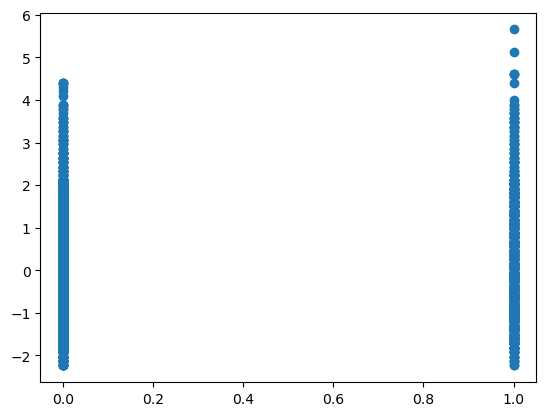

balance


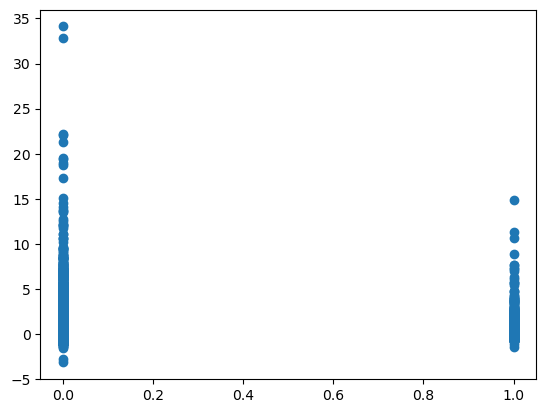

day


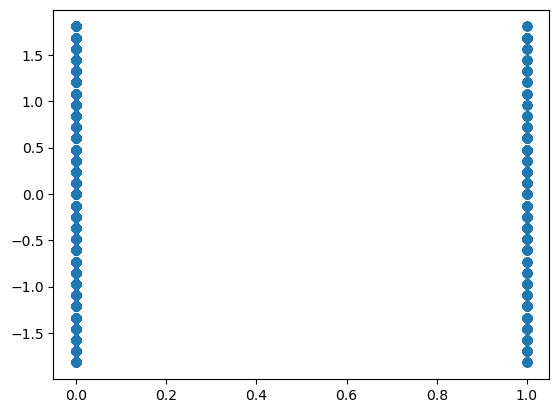

month


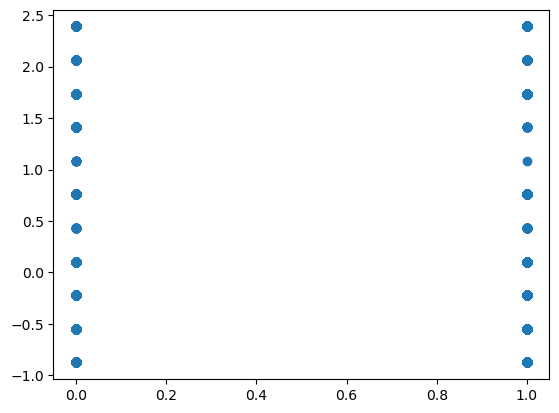

duration


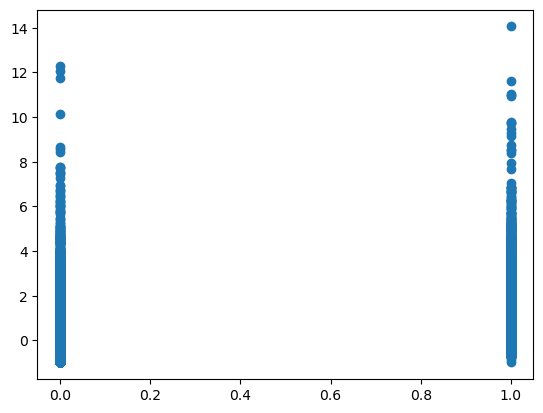

campaign


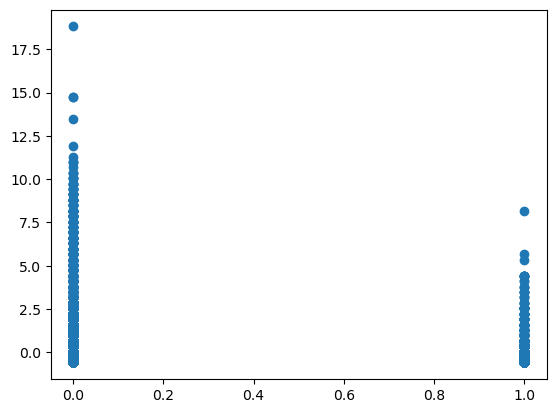

job_blue-collar


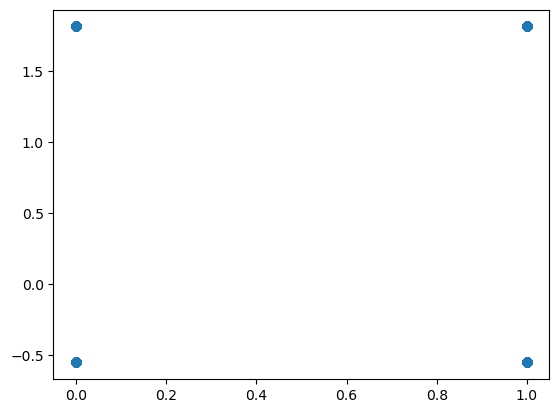

job_entrepreneur


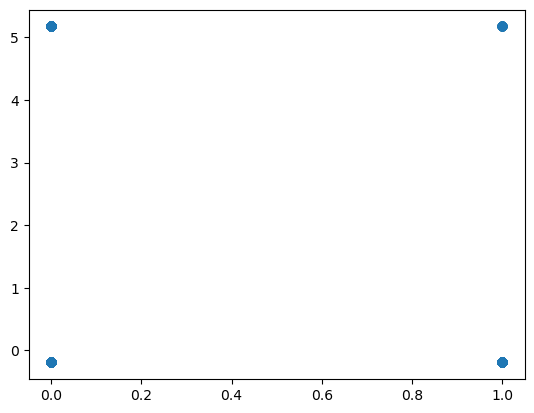

job_housemaid


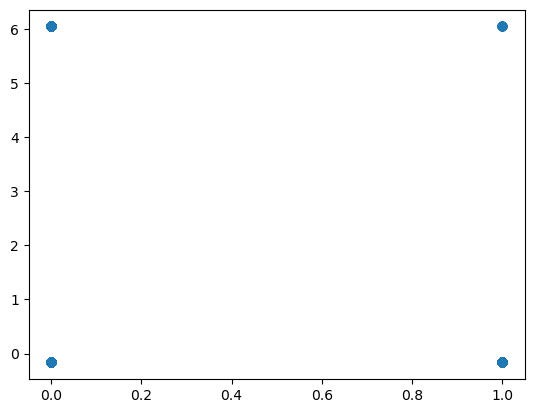

job_management


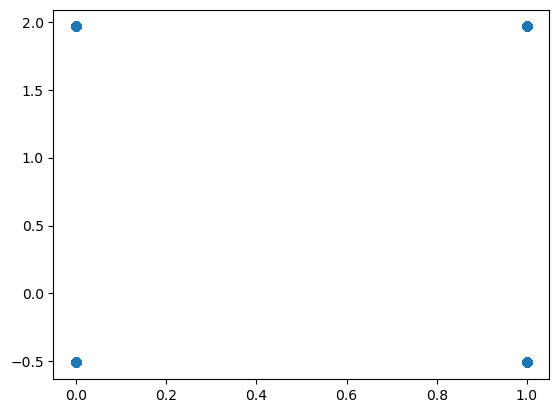

job_retired


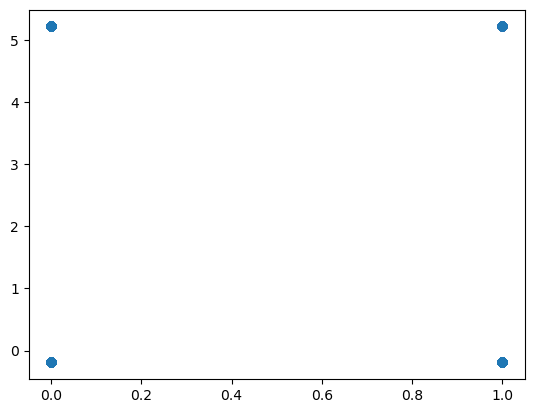

job_self-employed


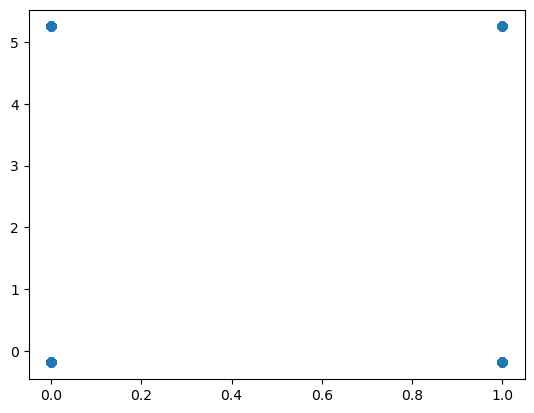

job_services


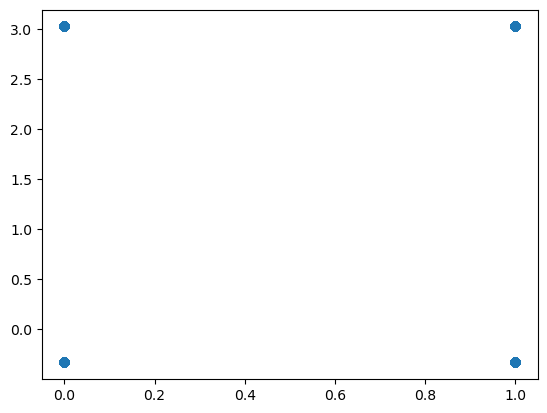

job_student


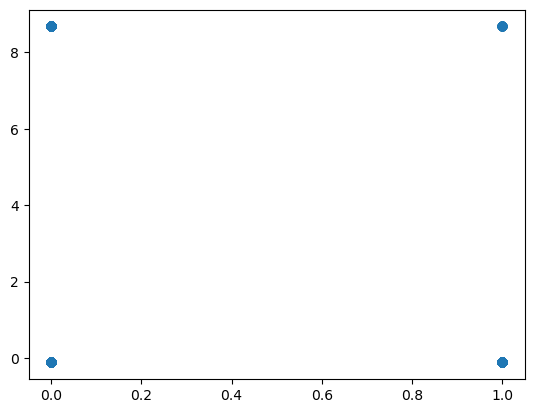

job_technician


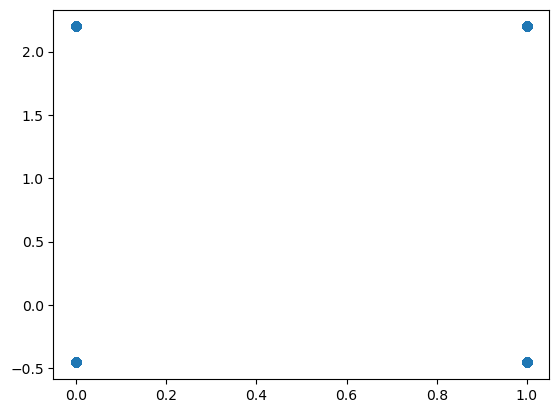

job_unemployed


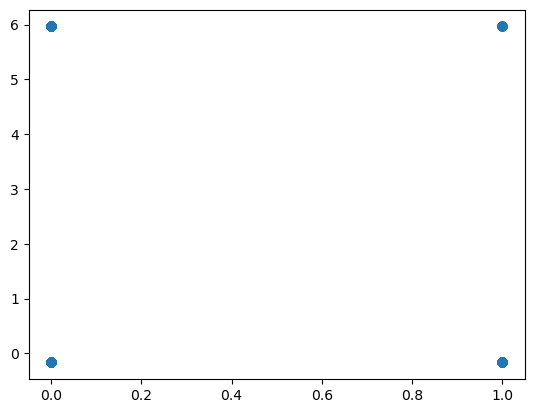

job_unknown


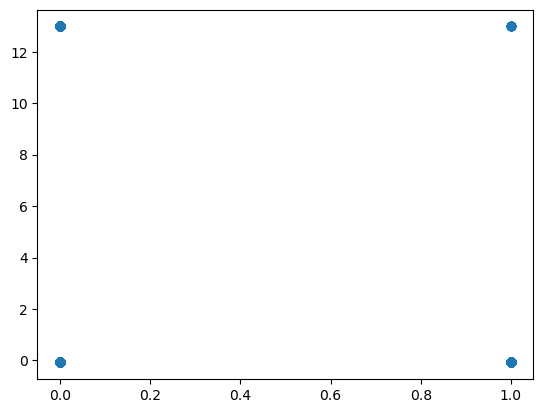

marital_married


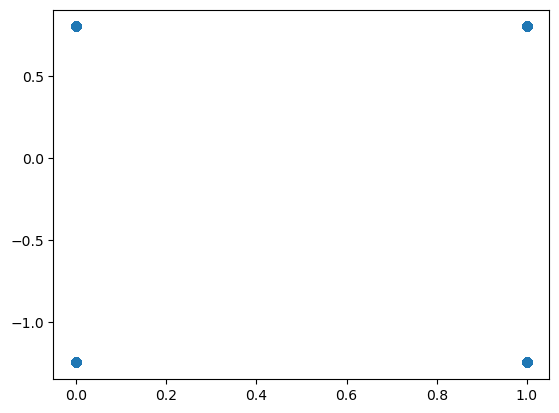

marital_single


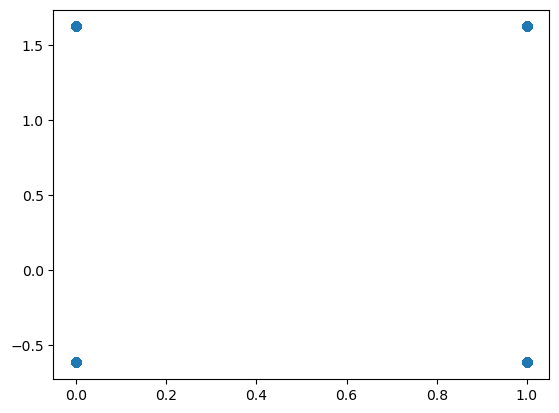

default_yes


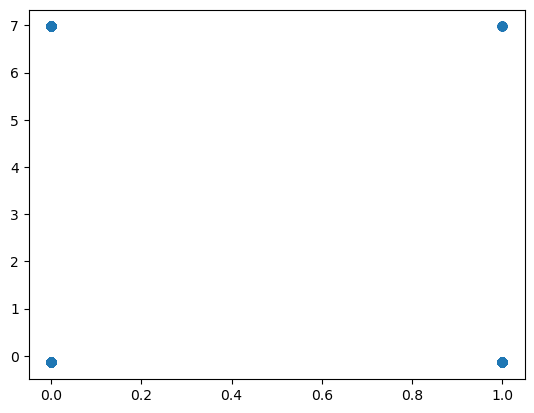

housing_yes


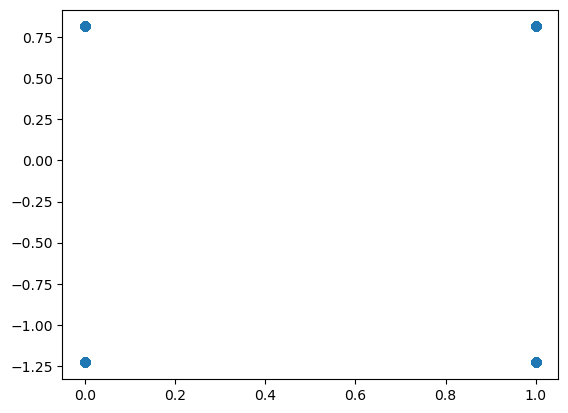

loan_yes


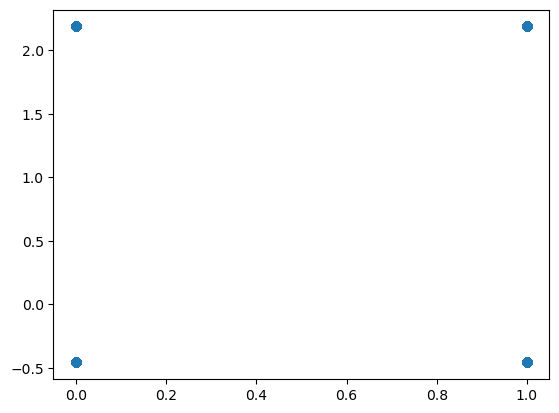

contact_telephone


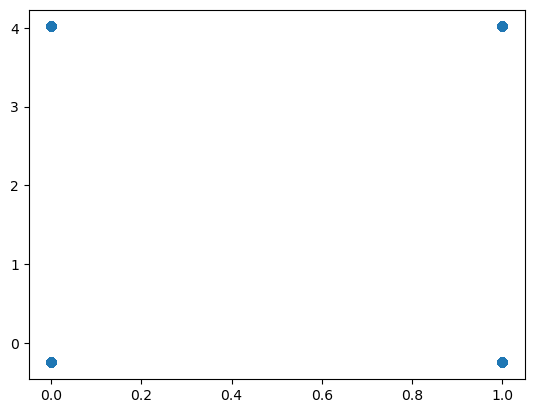

contact_unknown


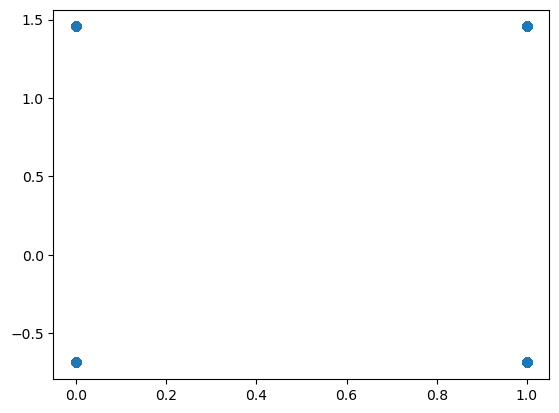

ordinal_education


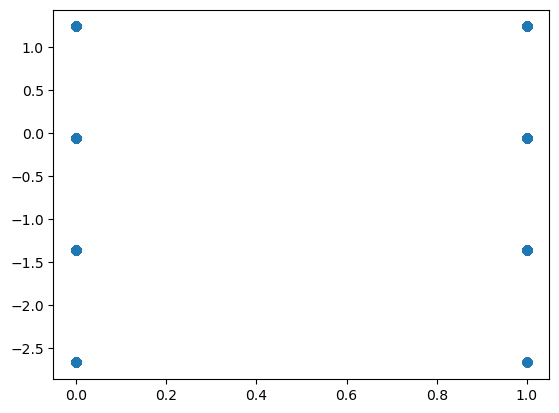

In [20]:
for col in X_train.columns:
    plt.figure()
    plt.scatter(y_train, scaled_X_train[col])
    plt.xlabel(col)
    plt.ylabel('y')
    plt.show()

### Randomized Grid Search

In [21]:
# Create the random grid
random_grid = {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 
                        'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
               'penalty': ['l2', 'l1', 'elasticnet', None],
               'alpha': [x/10 for x in range(1, 101)],
               'max_iter': [x for x in range(1000, 10000, 100)]}

In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
model = SGDClassifier(tol=1e-3, class_weight='balanced')
# search across 100 different combinations, and use all available cores
svm_random = RandomizedSearchCV(estimator=model, param_distributions = random_grid, n_iter = 100, cv = 5, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
svm_random.fit(scaled_X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mj/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SGDClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9, 1.0, 1.1, 1.2,
                                                  1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                                                  1.9, 2.0, 2.1, 2.2, 2.3, 2.4,
                                                  2.5, 2.6, 2.7, 2.8, 2.9, 3.0, ...],
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_huber',
                                                 'squared_hinge', 'perceptron',
                                                 'squared_error', 'huber',
                                                 'epsilon_insensitive',
                                                 'squared_epsilon_insensitive'],
                                        'max_iter': [1000, 1100, 1200, 1300,
                                                     1400, 1500, 1600, 1700,
                                                     1800, 1900, 2000, 2100,
                                                     2200, 2300, 2400, 2500,
                                                     2600, 2700, 2800, 2900,
                                                     3000, 3100, 3200, 3300,
                                                     3400, 3500, 3600, 3700,
                                                     3800, 3900, ...],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    None]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [23]:
best_svm = svm_random.best_estimator_
svm_random.best_estimator_

SGDClassifier(alpha=4.0, class_weight='balanced',
              loss='squared_epsilon_insensitive', max_iter=2800)

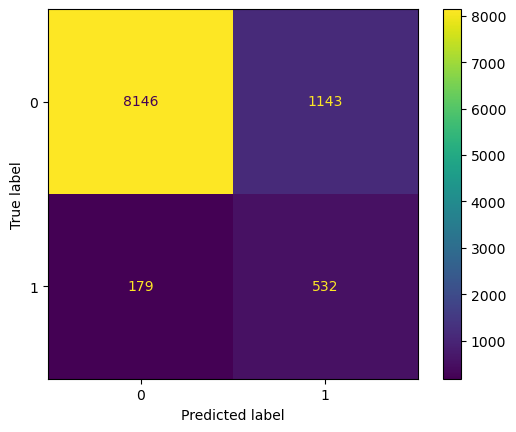

In [24]:
# Generate predictions with the best model
y_pred = best_svm.predict(scaled_X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2*precision*recall/(precision+recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)

roc_auc = roc_auc_score(y_test, y_pred)
print("Roc Auc:", roc_auc)

Accuracy: 0.8678
Precision: 0.3176119402985075
Recall: 0.7482419127988749
F1 score: 0.44593461860854994
Roc Auc: 0.8125965727198163
[CV] END alpha=3.8, loss=squared_error, max_iter=7900, penalty=elasticnet; total time=   0.1s
[CV] END alpha=4.6, loss=modified_huber, max_iter=9600, penalty=None; total time=   0.3s
[CV] END alpha=3.7, loss=squared_epsilon_insensitive, max_iter=9900, penalty=None; total time=   0.6s
[CV] END .alpha=5.5, loss=hinge, max_iter=7000, penalty=None; total time=   0.1s
[CV] END .alpha=6.0, loss=hinge, max_iter=5300, penalty=None; total time=   0.2s
[CV] END alpha=1.3, loss=huber, max_iter=2200, penalty=elasticnet; total time=   0.1s
[CV] END ...alpha=2.1, loss=hinge, max_iter=1500, penalty=l2; total time=   0.0s
[CV] END alpha=8.2, loss=log_loss, max_iter=3800, penalty=l1; total time=   0.1s
[CV] END alpha=8.2, loss=log_loss, max_iter=3800, penalty=l1; total time=   0.1s
[CV] END alpha=10.0, loss=squared_hinge, max_iter=1900, penalty=None; total time=   0.3s
[CV

[CV] END alpha=4.6, loss=modified_huber, max_iter=9600, penalty=None; total time=   1.1s
[CV] END alpha=8.6, loss=epsilon_insensitive, max_iter=7100, penalty=None; total time=   0.5s
[CV] END alpha=6.0, loss=epsilon_insensitive, max_iter=9600, penalty=None; total time=   0.3s
[CV] END alpha=7.8, loss=squared_epsilon_insensitive, max_iter=9700, penalty=l1; total time=   0.1s
[CV] END alpha=6.2, loss=squared_hinge, max_iter=9000, penalty=l1; total time=   0.1s
[CV] END alpha=6.2, loss=squared_hinge, max_iter=9000, penalty=l1; total time=   0.1s
[CV] END alpha=8.3, loss=perceptron, max_iter=9300, penalty=None; total time=   0.1s
[CV] END alpha=3.2, loss=squared_epsilon_insensitive, max_iter=1800, penalty=None; total time=   0.1s
[CV] END ...alpha=7.3, loss=huber, max_iter=9900, penalty=l2; total time=   0.0s
[CV] END ...alpha=6.7, loss=hinge, max_iter=9400, penalty=l2; total time=   0.0s
[CV] END .alpha=5.8, loss=hinge, max_iter=3400, penalty=None; total time=   0.1s
[CV] END alpha=8.0, l

[CV] END alpha=4.6, loss=modified_huber, max_iter=9600, penalty=None; total time=   0.2s
[CV] END alpha=8.0, loss=squared_epsilon_insensitive, max_iter=9400, penalty=elasticnet; total time=   0.1s
[CV] END alpha=3.7, loss=squared_epsilon_insensitive, max_iter=9900, penalty=None; total time=   0.1s
[CV] END ...alpha=3.5, loss=hinge, max_iter=3700, penalty=l2; total time=   0.1s
[CV] END alpha=6.5, loss=log_loss, max_iter=5300, penalty=l2; total time=   0.1s
[CV] END alpha=1.7, loss=squared_epsilon_insensitive, max_iter=5100, penalty=elasticnet; total time=   0.2s
[CV] END alpha=2.8, loss=hinge, max_iter=1400, penalty=elasticnet; total time=   0.1s
[CV] END .alpha=5.5, loss=hinge, max_iter=7000, penalty=None; total time=   0.1s
[CV] END .alpha=6.0, loss=hinge, max_iter=5300, penalty=None; total time=   0.1s
[CV] END alpha=8.6, loss=epsilon_insensitive, max_iter=7100, penalty=None; total time=   0.1s
[CV] END alpha=1.3, loss=huber, max_iter=2200, penalty=elasticnet; total time=   0.1s
[CV

[CV] END alpha=4.6, loss=modified_huber, max_iter=9600, penalty=None; total time=   0.5s
[CV] END alpha=6.5, loss=log_loss, max_iter=5300, penalty=l2; total time=   0.4s
[CV] END .alpha=5.5, loss=hinge, max_iter=7000, penalty=None; total time=   0.1s
[CV] END .alpha=6.0, loss=hinge, max_iter=5300, penalty=None; total time=   0.1s
[CV] END alpha=8.6, loss=epsilon_insensitive, max_iter=7100, penalty=None; total time=   0.2s
[CV] END ...alpha=2.1, loss=hinge, max_iter=1500, penalty=l2; total time=   0.2s
[CV] END alpha=10.0, loss=squared_hinge, max_iter=1900, penalty=None; total time=   0.5s
[CV] END alpha=6.2, loss=squared_hinge, max_iter=9000, penalty=l1; total time=   0.1s
[CV] END alpha=8.3, loss=perceptron, max_iter=9300, penalty=None; total time=   0.1s
[CV] END alpha=8.3, loss=perceptron, max_iter=9300, penalty=None; total time=   0.2s
[CV] END ...alpha=7.3, loss=huber, max_iter=9900, penalty=l2; total time=   0.0s
[CV] END ...alpha=7.3, loss=huber, max_iter=9900, penalty=l2; total